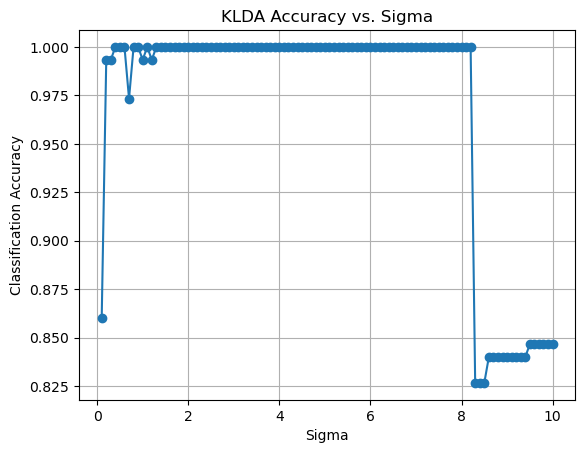

Best sigma: 0.40 with accuracy 1.0000


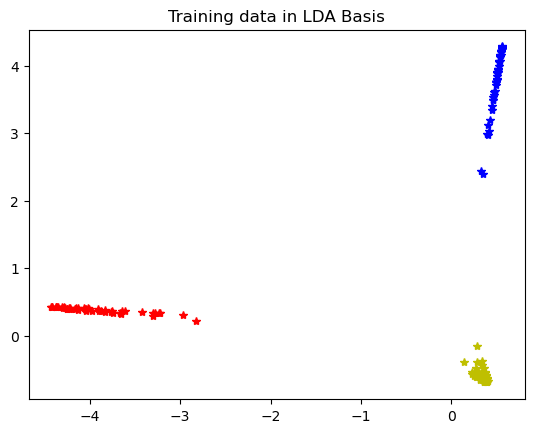

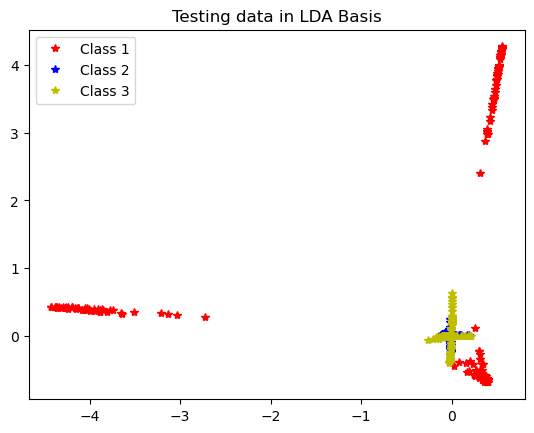

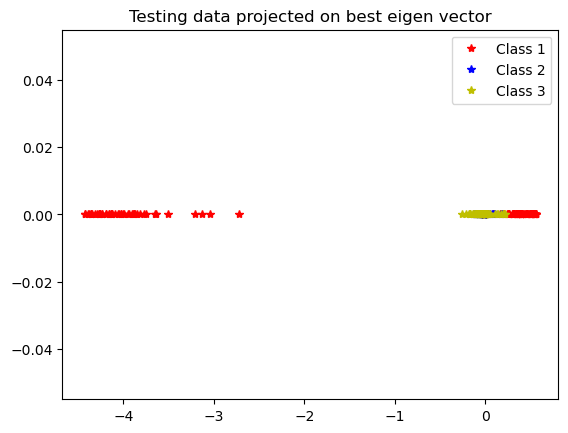

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, pinv
np.random.seed(0)
# Gaussian Kernel function
def gausskernel(x, y, sigma):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

# Data Generation for Class 1
M1 = np.array([1, 1])
CX1 = np.array([[0.5, 0.3], [0.3, 0.5]])
eigvals1, E1 = np.linalg.eigh(CX1)
X = np.random.randn(2, 100)*(0.2)
X1 = E1 @ np.diag(np.sqrt(eigvals1)) @ X + M1[:, np.newaxis]
# Data Generation for Class 2
M2 = np.array([-1, -1])
CX2 = np.array([[0.7, 0.1], [0.1, 0.7]])
eigvals2, E2 = np.linalg.eigh(CX2)
X = np.random.randn(2, 100)*(0.2)
X2 = E2 @ np.diag(np.sqrt(eigvals2)) @ X + M2[:, np.newaxis]
# Data Generation for Class 3
M3 = np.array([0, 0])
CX3 = np.array([[0.85, 0.6], [0.6, 0.85]])
eigvals3, E3 = np.linalg.eigh(CX2)
X = np.random.randn(2, 100)*(0.2)
X3 = E3 @ np.diag(np.sqrt(eigvals3)) @ X + M3[:, np.newaxis]

# Splitting of data into train and test based on random permutation
perm = np.argsort(np.random.rand(100))
TRAINDATA1 = X1[:, perm[:50]]
TRAINDATA2 = X2[:, perm[:50]]
TRAINDATA3 = X3[:, perm[:50]]
TESTDATA1 = X1[:, perm[50:]]
TESTDATA2 = X2[:, perm[50:]]
TESTDATA3 = X3[:, perm[50:]]

TRAINDATA = np.hstack((TRAINDATA1, TRAINDATA2, TRAINDATA3))
TESTDATA = np.hstack((TESTDATA1, TESTDATA2, TESTDATA3))

sigma_list = np.linspace(0.1, 10, 100)  # or any other list you prefer
accuracy_list = []

for sigma in sigma_list:
    # Gram matrix
    G = np.zeros((150, 150))
    for i in range(150):
        for j in range(150):
            G[i, j] = gausskernel(TRAINDATA[:, i], TRAINDATA[:, j], sigma)

    X1_kernel = G[:, :50]
    X2_kernel = G[:, 50:100]
    X3_kernel = G[:, 100:]

    # Mean vectors
    MEAN1 = np.mean(X1_kernel, axis=1)
    MEAN2 = np.mean(X2_kernel, axis=1)
    MEAN3 = np.mean(X3_kernel, axis=1)
    C = (MEAN1 + MEAN2 + MEAN3) / 3
    M1 = MEAN1[:, np.newaxis]
    M2 = MEAN2[:, np.newaxis]
    M3 = MEAN3[:, np.newaxis]
    C = C[:, np.newaxis]

    # Between-class scatter
    SB = 50 * ((M1 - C) @ (M1 - C).T + (M2 - C) @ (M2 - C).T + (M3 - C) @ (M3 - C).T)

    # Within-class scatter
    SW = 50 * ((X1_kernel - M1) @ (X1_kernel - M1).T +
               (X2_kernel - M2) @ (X2_kernel - M2).T +
               (X3_kernel - M3) @ (X3_kernel - M3).T)

    # Solving the eigenvalue problem
    eigvals, eigvecs = eigh(pinv(SW) @ SB)
    idx = np.argsort(eigvals)[::-1]
    E = eigvecs[:, idx[:2]]  # Only top 2 for projection

    # Projecting training data
    Y1 = E.T @ X1_kernel
    Y2 = E.T @ X2_kernel
    Y3 = E.T @ X3_kernel
    Y_train = np.hstack((Y1, Y2, Y3)).T
    labels_train = np.array([0]*50 + [1]*50 + [2]*50)

    # Projecting test data
    PR = []
    for i in range(150):
        temp = [gausskernel(TESTDATA[:, i], TRAINDATA[:, j], sigma) for j in range(150)]
        PR.append(E.T @ np.array(temp))
    PR = np.real(np.array(PR))  
    Y_test = PR                 
    labels_test = np.array([0]*50 + [1]*50 + [2]*50)

    # Classifying using nearest centroid
    centroids = [np.mean(Y_train[labels_train == i], axis=0) for i in range(3)]
    pred_labels = []
    for y in Y_test:
        dists = [np.linalg.norm(y - c) for c in centroids]
        pred_labels.append(np.argmin(dists))

    acc = np.mean(np.array(pred_labels) == labels_test)
    accuracy_list.append(acc)
    # print(f"Sigma = {sigma:.2f}, Accuracy = {acc:.4f}")

plt.figure()
plt.plot(sigma_list, accuracy_list, 'o-')
plt.xlabel("Sigma")
plt.ylabel("Classification Accuracy")
plt.title("KLDA Accuracy vs. Sigma")
plt.grid(True)
plt.show()

best_sigma = sigma_list[np.argmax(accuracy_list)]
print(f"Best sigma: {best_sigma:.2f} with accuracy {max(accuracy_list):.4f}")

# Parameter
sigma = best_sigma

# Construction of the Gram Matrix using gaussian kernel
G = np.zeros((150, 150))
for i in range(150):
    for j in range(150):
        G[i, j] = gausskernel(TRAINDATA[:, i], TRAINDATA[:, j], sigma)

X1_kernel = G[:, :50]
X2_kernel = G[:, 50:100]
X3_kernel = G[:, 100:]

# Calculation of means
MEAN1 = np.mean(X1_kernel, axis=1)
MEAN2 = np.mean(X2_kernel, axis=1)
MEAN3 = np.mean(X3_kernel, axis=1)

# Construction of Between-class scatter matrix
C=(MEAN1+MEAN2+MEAN3)/3
M1 = MEAN1[:, np.newaxis]  # shape (2,1)
M2 = MEAN2[:, np.newaxis]
M3 = MEAN3[:, np.newaxis]
C = C[:, np.newaxis]       # shape (2,1)
SB= 50*(((M1-C) @ (M1-C).T) + ((M2-C) @ (M2-C).T) + ((M3-C) @ (M3-C).T))

# Construction of Within-class scatter matrix
SW = 50 * ((X1_kernel - M1) @ (X1_kernel - M1).T +
      (X2_kernel - M2) @ (X2_kernel - M2).T +
      (X3_kernel - M3) @ (X3_kernel - M3).T)


# Solving the eigenvalue problem
eigvals, eigvecs = eigh(pinv(SW) @ SB)
# Sorting of eigenvalues and eigenvectors in descending order
idx = np.argsort(eigvals)[::-1]
E = eigvecs[:, idx]


# Projecting training data with respect to the eigen basis
Y1 = E.T @ X1_kernel
Y2 = E.T @ X2_kernel
Y3 = E.T @ X3_kernel

plt.figure(4)
plt.plot(Y1[0],Y1[1],'r*', label="Class 1")
plt.plot(Y2[0],Y2[1],'b*', label="Class 2")
plt.plot(Y3[0],Y3[1],'y*', label="Class 3")
plt.title("Training data in LDA Basis")
plt.legend


# Projecting test data
PR = []
for i in range(150):
    temp=[];
    for j in range(150):
        temp.append(gausskernel(TESTDATA[:, i], TRAINDATA[:, j], sigma))
    
    PR.append(E.T @ temp)

PR = np.real(np.array(PR).T)


plt.figure(5)
plt.plot(PR[:50][0],PR[:50][1],'r*', label="Class 1")
plt.plot(PR[50:100][0],PR[50:100][1],'b*', label="Class 2")
plt.plot(PR[100:][0],PR[100:][1],'y*', label="Class 3")
plt.title("Testing data in LDA Basis")
plt.legend()

plt.figure(6)
plt.plot(PR[:50][0],np.zeros_like(PR[:50][0]),'r*', label="Class 1")
plt.plot(PR[50:100][0],np.zeros_like(PR[50:100][0]),'b*', label="Class 2")
plt.plot(PR[100:][0],np.zeros_like(PR[100:][0]),'y*', label="Class 3")
plt.title("Testing data projected on best eigen vector")
plt.legend()